<a href="https://colab.research.google.com/github/vasantvohra/Fingerprint_Recognition/blob/master/Fingerprint_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary functions

In [ ]:
import cv2
import os
import sys
import numpy
import glob
import matplotlib.pyplot as plt

### Enhance images

- Ridge Segmentation -> Region of interest
- Ridge Orientation -> Every pixels orientation 
- Ridge Frequency -> Overall frequency of ridge
- Gabor Filter -> Ridge Filter

[Github Repo](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python)

In [ ]:
sys.path.append('../')
from enhance import image_enhance

### Skeletonize
- Morphological process for reducing foreground regions in a binary image to a skeletal remnant that largely preserves the extent & connectivity of original region, while throwing away most of the original foreground pixels.

In [ ]:
from skimage.morphology import skeletonize, thin

###  Ploting image

In [ ]:
def plot_figure(img1,img2,img3,a,b,c):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    ax1.imshow(img1, cmap = 'gray')
    ax2.imshow(img2, cmap = 'gray')
    ax3.imshow(img3, cmap = 'gray')

    ax1.set_title(f'{a}')
    ax1.axis('off')
    ax2.set_title(f'{b}')
    ax2.axis('off')
    ax3.set_title(f'{c}')
    ax3.axis('off')

### Thinning function instead of using ski image
- Removes dots and connects lines to find corners by Harris Corner Algorithm

In [ ]:
def removedot(invertThin):
    temp0 = numpy.array(invertThin[:])
    temp0 = numpy.array(temp0)
    temp1 = temp0/255
    temp2 = numpy.array(temp1)
    temp3 = numpy.array(temp2)

    enhanced_img = numpy.array(temp0) # why?
    filter0 = numpy.zeros((10,10))
    W,H = temp0.shape[:2]
    filtersize = 6

    for i in range(W - filtersize):
        for j in range(H - filtersize):
            filter0 = temp1[i:i + filtersize,j:j + filtersize]

            flag = 0
            if sum(filter0[:,0]) == 0:
                flag +=1
            if sum(filter0[:,filtersize - 1]) == 0:
                flag +=1
            if sum(filter0[0,:]) == 0:
                flag +=1
            if sum(filter0[filtersize - 1,:]) == 0:
                flag +=1
            if flag > 3:
                temp2[i:i + filtersize, j:j + filtersize] = numpy.zeros((filtersize, filtersize))
  
    return temp2


### CLAHE

Contrast Limited Adaptive Histogram Equalization - To prevent global histogram equalization
- Image is divided into small blocks openCV (8*8)
- Each of these blocks are histogram equalized as usual.
So in a small area, histogram would confine to a small region (unless there is noise),
if noise is there it will be amplified.
- To avoid this contrast limiting is applied.
- If any Histogram bin is above the specified contrast limit (default 40) 
Those pixels are clipped and distributed uniformly to other bins before apply histogram equalization.
- After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.
    

## Corner Harris Detection
- Algorithm to extract the corners of an image, which can be stored as a KeyPoint.

### ORB Descriptor
Oriented Fast And Rotated Brief
- Fast Keypoint detector & Brief Descriptor
- Fast & Accurate Orientation Component to FAST

In [ ]:
def get_descriptors(img):
    # Apply Clahe
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img1 = img * 255
    a = "CLAHE"
    # cv2.imshow("Clahe",img)
    
    # Enhance image
    img = image_enhance.image_enhance(img)
    img = numpy.array(img, dtype=numpy.uint8)
    # cv2.imshow("enhance",255*img)    
    img2 = img*255
    b = "Enhance"
    
    # Threshold
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Normalize to 0 and 1 range
    img[img == 255] = 1
    img3 = img
    c = "Normalize"
    # cv2.imshow("Threshold",img)
    
    plot_figure(img1,img2,img3,a,b,c)
    
    #Skeleton & Thinning
    skeleton = skeletonize(img)
    img1 = skeleton*255
    a = "Skeleton"
    # cv2.imshow("skeletonize",255*img)
    skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    #cv2.imshow("skeleton",skeleton)
    skeleton = removedot(skeleton)
    img2 = skeleton*255
    b = "Thinning"
    
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125
    
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
            for y in range(0, harris_normalized.shape[1]):
                    if harris_normalized[x][y] > threshold_harris:
                            #print(x,y)
                            keypoints.append(cv2.KeyPoint(y, x, 1))
    img3 = cv2.drawKeypoints(img, keypoints, outImage=None)
    c="Keypoints"
    plot_figure(img1,img2,img3,a,b,c)
    
    # Define descriptor
    orb = cv2.ORB_create() 
    # Compute descriptors
    _, des = orb.compute(img, keypoints)
    return (keypoints, des)

### Brute Force match
### Hamming distance

[Reference](https://pythonprogramming.net/feature-matching-homography-python-opencv-tutorial/)

### Score_Threshold - 35 below this is a match otherwise false (change Accordingly)

In [ ]:
def verify(img1,img2):
    img1 = cv2.imread(img1,0)
#    print("Original Image")
    kp1,des1 = get_descriptors(img1)
    img2 = cv2.imread(img2,0)
#    print("Candidate Image")
    kp2, des2 = get_descriptors(img2)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)
   # Plot keypoints
#    print("plotting on original images and match")
    img4 = cv2.drawKeypoints(img1, kp1, outImage=None)
    a = "Original Keypoints"
    img5 = cv2.drawKeypoints(img2, kp2, outImage=None)
    b = "Candidate Keypoints"
    img6 = cv2.drawMatches(img1, kp1, img2, kp2, matches, flags=2, outImg=None)
    c = "Match"
    plot_figure(img4,img5,img6,a,b,c)
    
    
    score = 0
    for match in matches:
            score += match.distance
    score_threshold = 36
    s = (score/len(matches) )
    if score/len(matches) < score_threshold:
        print(f"Fingerprint matches with Avg. Score = {s}")
    else:
        print(f"Fingerprint does not match with Avg. Score = {s}")


### 1:1 Match

Fingerprint matches with Avg. Score = 30.355555555555554


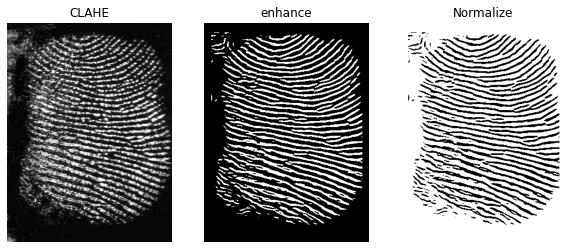

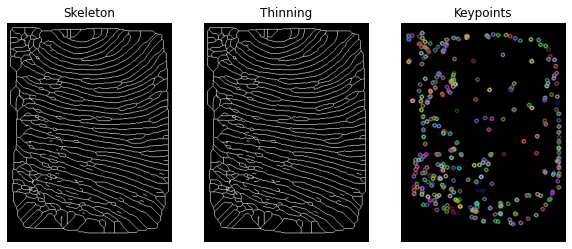

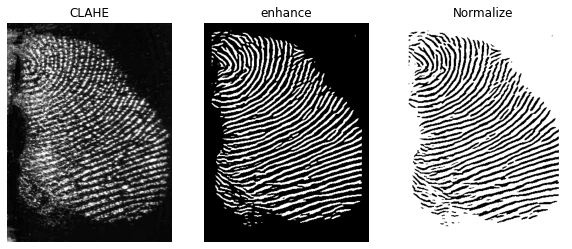

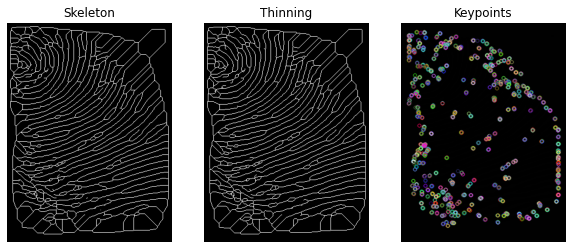

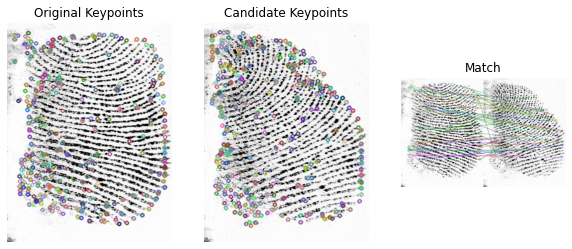

In [ ]:
img1 = "../Devashish/Normal/Right Thumb_158793710430.png"
img2 = "../Devashish/rotated/Right Thumb_158793731879.png"
verify(img1,img2)

### Descriptor function without plots

In [ ]:
def get_descriptors2(img):
    # Apply Clahe
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = image_enhance.image_enhance(img)
    img = numpy.array(img, dtype=numpy.uint8)
    # Thresholding image
    ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    # Normalize to 0 and 1 range
    img[img == 255] = 1

    #Thinning
    skeleton = skeletonize(img)
    skeleton = numpy.array(skeleton, dtype=numpy.uint8)
    skeleton = removedot(skeleton)
    
    # Harris corners
    harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
    harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
    threshold_harris = 125
    
    # Extract keypoints
    keypoints = []
    for x in range(0, harris_normalized.shape[0]):
            for y in range(0, harris_normalized.shape[1]):
                    if harris_normalized[x][y] > threshold_harris:
                           # print(x,y)
                            keypoints.append(cv2.KeyPoint(y, x, 1))
    # Define descriptor
    orb = cv2.ORB_create()
    # Compute descriptors
    _, des = orb.compute(img, keypoints)
    return (keypoints, des)

## Saving keypoints in file for 1:N match

In [ ]:
import pickle
import base64

In [ ]:
def filekeypoints():
    path = "./Devashish/Normal/"
    files = glob.glob(f"{path}*.png", recursive = True)
    filenames = []
    for file in files:
        filenames.append(file)
    for image in filenames:
        image1 = cv2.imread(image,0)
        keypoint,descriptor = get_descriptors2(image1)
        index = []
        
        for point in keypoint:    
            temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id,descriptor)
        print(temp)
        index.append(temp)
        print(index)
    # b64 = base64.b64encode(index)
    #  Dump the keypoints
        filename = image[:-3]
        f = open(f"{filename}.txt", "wb")
        f.write(pickle.dumps(b64))
        f.close()

### Save keypoints in the file error - Pickling and unpickling while matching

In [ ]:
def matchfile(image1 = r"..\Devashish\rotated\Left Thumb_158793731886.png"):
    # load user image
    #image1 = input("please enter path of your finger scan")
    image1 = cv2.imread(image1,0)
    # get keypoints and descriptor from the function
    #CLAHE #Enhance #Skeltonize #
    keypoint,descriptor = get_descriptors2(image1)

    # ids list
    Matched=[]
    path = "../Devashish/Normal/"
    files = glob.glob(f"{path}*.txt", recursive = True)
    filenames = []
    for file in files:
        filenames.append(file)

    for txt in filenames:
        f = open(txt,"rb")
        index = f.read()
        index = base64.b64decode(index)
        #index = pickle.loads(f)
        kp = []
        for point in index:
            temp_feature = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5],) 
            kp.append(temp_feature)
            temp_descriptor = point[6]

        # Matching between Descirptors
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = sorted(bf.match(descriptor, temp_descriptor), key= lambda match:match.distance)
        score = 0
        for match in matches:
            score += match.distance
        score_threshold = 33
        
        s = (score/len(matches) )
        if score/len(matches) < score_threshold:
            print(f"Fingerprint matches. Avg. Score = {s}")
            print(filename)
            matched.append(filename)
        else:
            print(f"Fingerprint does not match. Avg. Score = {s}")
            print(filename)
    print(Matched)

In [ ]:
matchfile()

In [ ]:
def matchwImage(image1 = r"../Devashish\rotated\Left finger(1)_158793731823.png"):
    image1 = cv2.imread(image1,0)
    keypoint,des1 = get_descriptors2(image1)

    path = "../Devashish/Normal/"
    files = glob.glob(f"{path}*.png", recursive = True)
    filenames = []
    for file in files:
        filenames.append(file)
    for image in filenames:
        image1 = cv2.imread(image,0)
        keypt,des2 = get_descriptors2(image1)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)

        score = 0
        for match in matches:
                score += match.distance
        score_threshold = 33
        s = (score/len(matches))
        if score/len(matches) < score_threshold:
            print(f"Fingerprint matches with {image}. Avg. Score = {s}")
        else:
            print(f"Fingerprint does not match with {image}. Avg. Score = {s}")

## Left finger matches with various other fingers therefore, failed 1:N

In [ ]:
matchwImage()

Fingerprint matches with ../Devashish/Normal\Left Finger(1)_15879371041.png. Avg. Score = 23.94736842105263
Fingerprint does not match with ../Devashish/Normal\Left Finger(2)_158793710433.png. Avg. Score = 34.78260869565217
Fingerprint does not match with ../Devashish/Normal\Left Finger(3)_158793710494.png. Avg. Score = 37.734693877551024
Fingerprint matches with ../Devashish/Normal\Left Finger(4)_158793710492.png. Avg. Score = 32.791666666666664
Fingerprint does not match with ../Devashish/Normal\Left Thumb_158793710410.png. Avg. Score = 37.16
Fingerprint matches with ../Devashish/Normal\Right Finger(1)_158793710493.png. Avg. Score = 28.0
Fingerprint matches with ../Devashish/Normal\Right Finger(2)_158793710441.png. Avg. Score = 31.23404255319149
Fingerprint does not match with ../Devashish/Normal\Right Finger(3)_1587937104100.png. Avg. Score = 33.8936170212766
Fingerprint does not match with ../Devashish/Normal\Right Finger(4)_158793710491.png. Avg. Score = 33.68627450980392
Fingerpr